# Document clustering with LSI, LDA, and HDP

Practical course material for the ASDM Class 09 (Text Mining) by Florian Leitner.

© 2017 Florian Leitner. All rights reserved.

## Introduction

This notebook discusses a use-case of LSI, using [gensim](http://radimrehurek.com/gensim/index.html), closely following [its own tutorial for topic modeling](https://nbviewer.jupyter.org/github/RaRe-Technologies/gensim/blob/develop/docs/notebooks/gensim_news_classification.ipynb).

## Setup

The tutorial corpus gensim provides is the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF), but shortened to 300 documents, from the Australian Broadcasing Coporation's news mail serivce, and from around the years 2000-2001.

In [1]:
import gensim
import os

# show text as HTML
from IPython.display import HTML

test_data_dir = os.sep.join([
    gensim.__path__[0], 'test', 'test_data'
])
lee_train_file = (
    test_data_dir + os.sep + 'lee_background.cor'
)

with open(lee_train_file) as f:
    for n, l in enumerate(f):
        if n < 5:
            print(l[:60], "...")

Hundreds of people have been forced to vacate their homes in ...
Indian security forces have shot dead eight suspected milita ...
The national road toll for the Christmas-New Year holiday pe ...
Argentina's political and economic crisis has deepened with  ...
Six midwives have been suspended at Wollongong Hospital, sou ...


The first step is to load the documents and do a simple tokenization with gensim.
The `gensim.util.tokenize` method (used by `simple_preprocess`) split text into contiguous tokens of alphabetic characters (e.g., removing digits!), and `simple_preprocess` by default lower-cases all tokens.
In a sense, this is quite some harsh preprocessing, but is useful for tutorials and/or very noisy texts.

In [2]:
from gensim.utils import simple_preprocess

def read_and_tokenize(file_path):
    with open(file_path) as f:
        for doc in f:
            # strip accents and tokens
            # with less than 3 characters
            # NB: implicitly removes tokens
            # *longer* than 15 characters
            yield simple_preprocess(
                doc,
                deacc=True,
                min_len=3)

In [3]:
raw_documents = list(read_and_tokenize(
    lee_train_file))

len(raw_documents)

300

We will be looking at the [LSI](https://radimrehurek.com/gensim/models/lsimodel.html#gensim.models.lsimodel.LsiModel) and [LDA models](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel); To speed up computations a bit, we will be using gensim's [multicore implementation for LDA](https://radimrehurek.com/gensim/models/ldamulticore.html#module-gensim.models.ldamulticore).

In [4]:
from gensim.models import LsiModel, LdaModel
# disable this line if your CPU has only one core:
from gensim.models.ldamulticore import LdaMulticore as LdaModel

## Data preparation

First, we will do a little trick we will actually only learn about in the future, but that will *vastly* improve performace: detecting collocations (roughly, idioms), lemmatize the words ("am" -> "be", "going" -> "go", "men" -> "man", etc.), and remove **stopwords** (ubiquitious words found almost in any text that are not *very* siginificant for the text's semantics).

In [5]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

collocations = Phraser(Phrases(raw_documents))
lemmatizer = WordNetLemmatizer()
lemmatize = lambda t: lemmatizer.lemmatize(t, pos='v')
stopwords_en = (frozenset(stopwords.words('english'))
                | frozenset(["also"]))

In [6]:
def preprocess(doc):
    """
    Stopword filtering,
    collocation detection (joining),
    and token lemmatization.
    """
    
    doc_filtered = filter(
        lambda w: w not in stopwords_en,
        doc)
    doc_colloc = collocations[doc_filtered]
    doc_lemmas = map(lemmatize, doc_colloc)
    # journalist love the word "say" in all its 
    # forms - sayed, saying, says, ...
    # so we filter it *after* lemmatizing
    return [l for l in doc_lemmas if l != "say"]

HTML(" ".join(preprocess(raw_documents[6][:50])))

In [7]:
texts = list(map(preprocess, raw_documents))

Finally, we convert the documents (which by now are token sequences/lists) into numeric vectors, using the Bag-of-Word approach (i.e., ignoring token order, only measuring token *frequency*).

In [8]:
from gensim.corpora import Dictionary

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(doc) for doc in texts]

print(corpus[6][:10])

[(4, 1), (18, 2), (19, 1), (58, 1), (64, 3), (92, 1), (94, 1), (114, 1), (122, 1), (127, 1)]


## LSI Clustering

Latent semantic indexing ranks topics and `gensim` outputs them in a ranked order. However, LSI requires a `num_topics` parameter (set to 200 by default) to determine the number of latent dimensions after the SVD step.

In [14]:
lsimodel = LsiModel(
    corpus=corpus,
    num_topics=8,
    id2word=dictionary)

results = []

for t in lsimodel.show_topics():
    results.append(
        "<h3>Topic {}</h3>\n<p>{}</p>".format(*t)
    )

HTML("\n".join(results))

## Evaluating cluster coherence

Gensim can measure [topic coherence](https://radimrehurek.com/gensim/models/coherencemodel.html) following a meta-model by [Röder et al. (2015)](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) that combines several different approaches of measuring [word] topic/cluster coherence.

In [10]:
from gensim.models import CoherenceModel

def get_topic_words(lsi_model):
    topic_list = lsi_model.show_topics(formatted=False)
    return [[word for word, prob in wp_pairs]
            for topic_id, wp_pairs in topic_list]

# window_size defines the "context"
# tokens for the probability model
# (see section 3.2, "Boolean sliding
#  window" in Röder et al.)
CoherenceModel(
    topics=get_topic_words(lsimodel),
    texts=texts,
    dictionary=dictionary,
    window_size=10).get_coherence()

0.41634396699988108

With this, we can now estimate a good value for `num_topics` - simply by clustering with a range of topic numbers that seem realistic and picking the best result.

In [11]:
def evaluate_graph(
    dictionary,
    corpus,
    texts,
    min_num=3,
    max_num=15):
    
    n_topics = list(range(min_num, max_num + 1))
    scores = []
    
    for num_topics in n_topics:
        lm = LsiModel(
            corpus=corpus,
            num_topics=num_topics,
            id2word=dictionary)
        
        cm = CoherenceModel(
            topics=get_topic_words(lm),
            texts=texts,
            dictionary=dictionary,
            window_size=10)     
        
        scores.append(cm.get_coherence())
        
    plt.plot(n_topics, scores)
    plt.xlabel("N. topics")
    plt.ylabel("Coherence score")
    plt.show()

Populating the interactive namespace from numpy and matplotlib


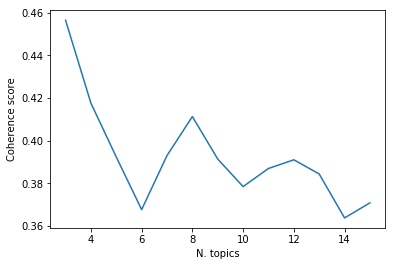

CPU times: user 5.01 s, sys: 327 ms, total: 5.34 s
Wall time: 3.95 s


In [12]:
%pylab inline --no-import-all
%time evaluate_graph(dictionary, corpus, texts)

If all went "according to plan", you should see that the best topic coherence is found at 3 topics, explaining our choice above (which was correct after finding this result).

## LSI conclusions

LSI clustering is relatively simple to implement.
Its biggest (in fact, quite significant) drawback maybe is that it scales poorly with corpus size.
Finally, note that a trained LSI model can be used to predict the topic/cluster distribution in new, unseen documents, just like this:

`doc_topics = lsi_model[dictionary.doc2bow(preprocess(raw_doc))]`

***
***
***

## LDA clustering

Similar to LSI, LDA can also be used to bootstrap clusters, and again a `num_topics` hyper-parameter is the "hardest" part about setting up this clustering algorithm.

**WARNING**: LDA more expensive to run; expect long computations ahead if you are working with old hardware.

In [15]:
# the "best" num_topics was estimated by 
# replacing `LsiModel` in `evaluate_graph` with `LdaModel`
ldamodel = LdaModel(
    corpus=corpus,
    num_topics=11,
    id2word=dictionary)

Now onto somthing cool - visually exploring the LDA model's results. Note that you need [`pyLDAvis`](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb) installed for this step, e.g.:

- `conda install pyLDAvis`
- `pip3 install pyLDAvis`

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
# enable this line:
# (disabled to save horizontal screen space)
#pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

The circles' sizes are proportional to the proportions of the topics, using the "default" topic if no term is selected. The red bars represent the topic's weight for that term, the blue bars the overall term frequency. $\lambda$ controls how term relevance is ranked. With a selected term, the circle sizes represent topic-term proportions. More information can be found in the original [R Vignette](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf).

## LDA coherence score

In [18]:
ldatopics = ldamodel.show_topics(formatted=False)
topics = [[word for word, prob in topic]
          for topicid, topic in ldatopics]

CoherenceModel(topics=topics,
               texts=texts,
               dictionary=dictionary,
               window_size=10).get_coherence()

0.32927206726201924

As described before, the LDA model's `num_topics` was set up to use the value that produces the highest coherence score.
Yet, the coherence score still is a distant second to what LSI produced.
So how do we use LDA "correctly" to get good (better than LSI) results?


## Cherry-picking the best LDA topics

One of the problems with LDA is that if we train it on a large number of topics, the topics get "lost" among the numbers. With the below function, we sort each *topic* in a LDA model with 100 topics (the default number of topics for `LdaModel`) and then go cherry-picking the  model that has at least one very coherent topic, and then will select the most coherent topics among it.

**WARNING:** LDA is very resource-hungry, computationally speaking; And this particular "setup" will take quite some time even on a modern laptop. If you have an old machine, this search can take dozens of minutes. On my machine MBP, this cell routinely takes around 2-5 minutes to complete.

**HUGE WARNING**: This is LDA -- and as such, the loop below might not converege; If after around ten runs (print statement) you get no result (because no topic reached the required coherence), you are better of restarting this cell.

In [19]:
%%time

import operator

def find_top_topics():
    top_topics = [(0, 0)]
    
    # create models until the top topic
    # reaches the indicated coherence score:
    while top_topics[0][1] < 0.95:
        
        lm = LdaModel( # num_topics=100 by default
            workers=4, # from LdaMuliticore
            corpus=corpus,
            id2word=dictionary)
        coherence_values = {}
        topic_idx = lm.show_topics(
            num_topics=-1,
            formatted=False)
        
        for n, topic in topic_idx:
            topic = [word for word, _ in topic]
            
            cm = CoherenceModel(
                topics=[topic],
                texts=texts,
                dictionary=dictionary, 
                window_size=10)
            
            coherence_values[n] = cm.get_coherence()
            
        top_topics = sorted(
            coherence_values.items(),
            key=operator.itemgetter(1),
            reverse=True)
        print(top_topics[0])

    return lm, top_topics

lsildamodel, top_topics = find_top_topics()

(43, 0.94240695001394914)
(85, 0.94352607913652609)
(74, 0.78718310305528516)
(41, 0.87722206782657075)
(74, 0.93087588176716329)
(33, 0.86980675820426723)
(16, 0.97137951353996921)
CPU times: user 1min 23s, sys: 1.93 s, total: 1min 25s
Wall time: 1min 25s


In [20]:
lsildamodel.show_topic(top_topics[0][0])

[('fire', 0.025204164466972451),
 ('line', 0.012416616962475485),
 ('north', 0.011203253029828619),
 ('burn', 0.0084761298283863428),
 ('south', 0.0081300712753220542),
 ('sydney', 0.0080226980343572445),
 ('containment', 0.0079644472525016736),
 ('rural_fire', 0.0076110078396065635),
 ('state', 0.0073798836120755728),
 ('west', 0.0072537481849166453)]

In [21]:
HTML("\n".join([
    "<h3>Topic {}</h3><p>Coherence score: {:.3f}</p><p>{}</p>".format(
        topicid, c_v,
        " + ".join('"{}"={:.2e}'.format(w.replace('_', " "), p)
                  for w, p in lsildamodel.show_topic(topicid))
    )
    for topicid, c_v in top_topics[:5]
]))

In [23]:
word_probs = lambda topicid: lsildamodel.show_topic(topicid)
lda_lsi_topics = [[word for word, prob in word_probs(t_id)]
                  for t_id, c_v in top_topics]

CoherenceModel(
    topics=lda_lsi_topics[:5], # top n using the results above
    texts=texts,
    dictionary=dictionary,
    window_size=10).get_coherence()

0.86031333051745262

## Conclusion

With "LDA as LSI", we managed to beat our best LSI model, by selecting the four most coherent topics out of 100 - but at quite some "computational cost".

## HDP (Hierarchical Dirichlet process) clustering

Despite being beyond the content of the lecture, **nonparametric** [HDP clustering by Wang et al. (2011)](http://proceedings.mlr.press/v15/wang11a/wang11a.pdf) should be mentioned here for completeness.

In [25]:
from gensim.models import HdpModel

hdpmodel = HdpModel(
    corpus=corpus,
    id2word=dictionary)

topic_words = []

for topic in hdpmodel.show_topics():
    topic_words.append(
        "<h3>Topic {}</h3>\n<p>{}</p>\n".format(*topic)
    )
    
hdptopics = hdpmodel.show_topics(formatted=False)
topics = [[word for word, prob in topic]
          for topicid, topic in hdptopics]

print("N. topics =", len(topics))
print("Coherence =", CoherenceModel(
    topics=topics,
    texts=texts,
    dictionary=dictionary,
    window_size=10).get_coherence())

HTML("\n".join(topic_words))

N. topics = 20
Coherence = 0.559653747665


HDP clustering was much faster that LDA, required no estimation of the number of topics, and has acceptable results in terms of coherence. At the very least a solid baseline to drive your LDA-based clustering work against!